# Analysis of Optimal Retention

This notebook explores how to effectively determine optimal retention.

All simulations in this notebook start from a new collection and use the default parameters (and assume the default parameters accurately describe the forgetting curve for the simulated user).

In [1]:
import matplotlib.pyplot as plt

## 1. Optimal Retention Analysis: Current Approach
We run simulations with a range of target retentions and a fixed daily time budget (e.g. 30 minutes).

Reviews are assumed to take a fixed time, so this is equivalent to a fixed review count (with new cards added to fill up to this review count when there are fewer reviews due).

Daily budget: 1800s, Mean duration: 5.00s
Simulating ret=0.1...
Simulating ret=0.2...
Simulating ret=0.3...
Simulating ret=0.4...
Simulating ret=0.5...
Simulating ret=0.6...
Simulating ret=0.7...
Simulating ret=0.8...
Simulating ret=0.9...
Simulating ret=0.95...


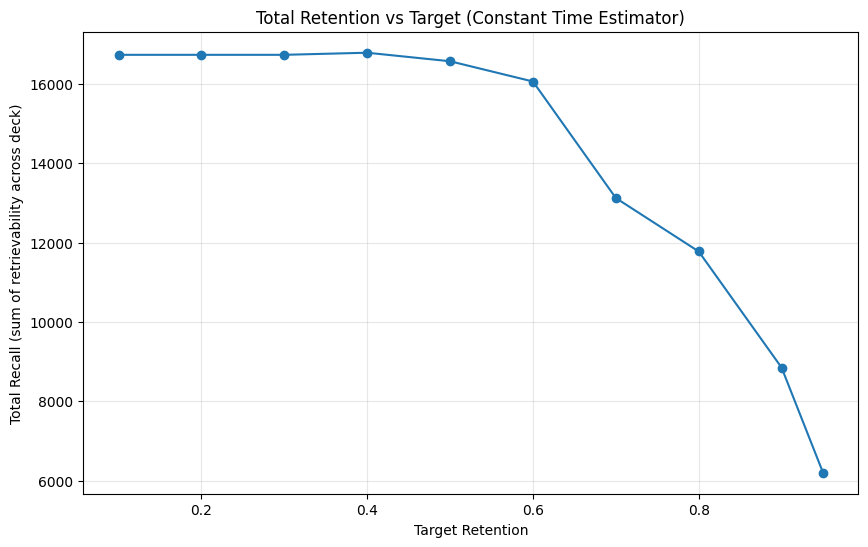

In [2]:
from simulate_fsrs import run_simulation

daily_budget_sec = 30 * 60  # 30 minutes
mean_duration_sec = 5.0  # Mean review duration in seconds
print(f"Daily budget: {daily_budget_sec}s, Mean duration: {mean_duration_sec:.2f}s")

retentions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
metrics = []


def constant_time_estimator(card, rating, current_date):
    return mean_duration_sec


for ret in retentions:
    print(f"Simulating ret={ret}...")
    _, _, sim_metrics = run_simulation(
        n_days=180,
        retention=str(ret),
        time_limit=daily_budget_sec,
        time_estimator=constant_time_estimator,
        verbose=False,
    )
    metrics.append(sim_metrics)

# Extract totals for plotting
totals = [m["total_retention"] for m in metrics]

plt.figure(figsize=(10, 6))
plt.plot(retentions, totals, marker="o")
plt.title("Total Retention vs Target (Constant Time Estimator)")
plt.xlabel("Target Retention")
plt.ylabel("Total Recall (sum of retrievability across deck)")
plt.grid(True, alpha=0.3)
plt.show()

Lower target retentions (below a certain point, 0.4 in the above plot) give higher target retention at end of simulation period.

At these low target retentions, intervals given after a review are longer than the simulation period. In this case the simulator only ever reviews new cards.

The total retention calculated only takes into account the cards which have been seen at least once in that simulation, effectively labelling all unseen cards with a retention of zero. Reviewing an unseen card then gives a massive boost to this assumed zero retention which persists for a long time (the forgetting curve gradient is very small beyond 0.7 retention).

This biases the optimization towards settings which lead to more reviews on previously unseen cards, which is expressed by optimal target retention being so low.

## 2. Optimal Retention Analysis: Fixing Low Retention Bias
Zero retention for new cards is incorrect; we do not always grade new cards `AGAIN`. We can check historical review data to find the rate we mark new cards `AGAIN`, and that gives the average retention for unseen cards as `1 - P(AGAIN)`. For my decks this can be around 0.5.

"Fair" simulations must account for this latent knowledge across unseen cards. To do this, find the maximum number of cards seen across all simulations and pad the total retention of simulations with fewer seen cards with `ΔCards (1 - P(AGAIN))`.

In [3]:
import numpy as np

# Calculate Adjusted Retention

# 1. Determine N_max (baseline population size)
max_cards = max(m["card_count"] for m in metrics)

# 2. Baseline retention for unseen cards
prob_first_success = 0.5  # Matches some typical decks
r_baseline = prob_first_success


def get_adjusted_total(metrics_list, max_n, r_base):
    adjusted = []
    for m in metrics_list:
        # Current sum of retention for studied cards
        current_total = m["total_retention"]
        # Add hypothetical retention for cards we "could have" studied
        missing_cards = max_n - m["card_count"]
        # Ensure we don't subtract if a run somehow exceeded the max (unlikely)
        padding = max(0, missing_cards) * r_base
        adjusted.append(current_total + padding)
    return adjusted


adj_metrics = get_adjusted_total(metrics, max_cards, r_baseline)

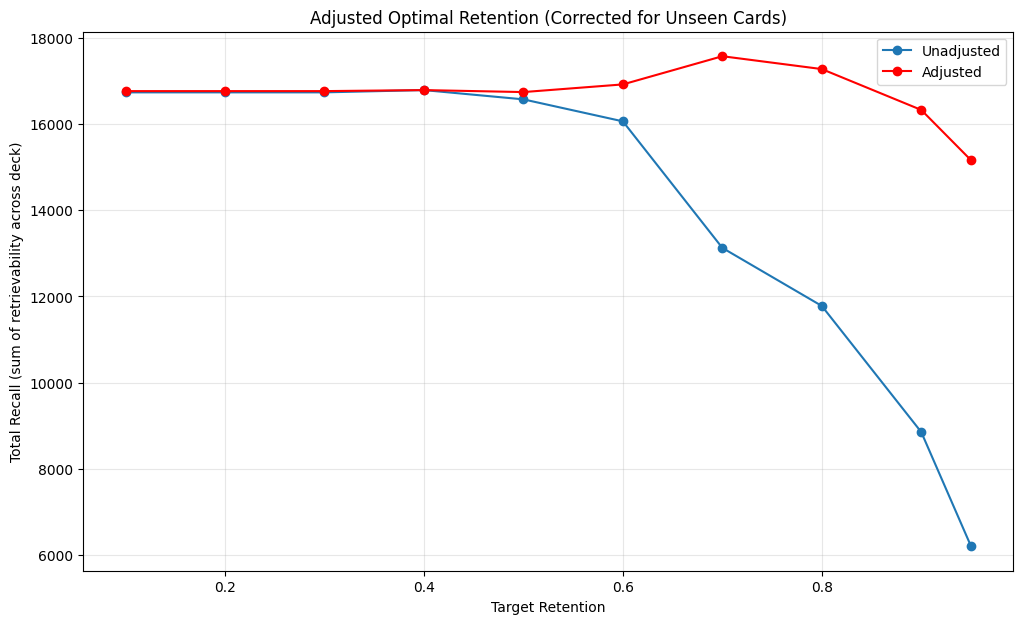

In [4]:
# Plot Adjusted Curves
plt.figure(figsize=(12, 7))
plt.plot(retentions, totals, marker="o", label="Unadjusted")
plt.plot(retentions, adj_metrics, marker="o", color="red", label="Adjusted")

# Highlight new optimals
opt_idx_c = np.argmax(totals)
opt_idx_l = np.argmax(adj_metrics)

plt.title("Adjusted Optimal Retention (Corrected for Unseen Cards)")
plt.xlabel("Target Retention")
plt.ylabel("Total Recall (sum of retrievability across deck)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()